(advanced-data)=
# Advanced Data


## Introduction

In this chapter, you'll learn about advanced methods for working with data.

### Imports

First we need to import the classic packages we almost always need:

In [29]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [30]:
# Set max rows displayed for readability
pd.set_option("display.max_rows", 6)
# Plot settings
plt.style.use(
    "https://github.com/aeturrell/coding-for-economists/raw/main/plot_style.txt"
)

## Data Validation

When working with data, it's useful to have a way to validate that what you're getting is what you *think* you're getting. And so various data validation methods have appeared that will fail loudly and proudly when your data are not as expected. Although most useful in a situation where data are being regularly updated, for example when producing a monthly index, these tools can also be useful if you want to be extra careful with your data in a research paper, if you are scaling up from a sample to a bigger dataset, or if you are updating an existing project.

Of course, the most minimal way to do some validation is to ensure that your dataframe has its columns cast as the right data types from the start, and this is good practice in general. That's about *data type*, but these tools go beyond that and deal with values *within* a data type. So rather than just saying it's an integer, a data validation library might say that a column must be an integer between 0 and 100.

The normal way that data validation libraries are used is that you specify some expectations you have of the dataset that will be flagged if and when they fail. Let's see some of the tools that are available that do this. As ever, this chapter has benefitted enormously from the documentation of the featured packages.

### Pandera

[**Pandera**](https://pandera.readthedocs.io/en/stable/index.html) {cite}`niels_bantilan-proc-scipy-2020` has tight integration with **pandas** (as the name suggests). There are several different ways to specify data validation checks.

#### Dataframe style checks

It's easiest to show how it works with an example. We'll first create some data that we'd like to validate.

In [31]:
import pandera as pa

# data to validate
df = pd.DataFrame(
    {
        "column1": [1, 4, 0, 10, 9],
        "column2": [-1.3, -1.4, -2.9, -10.1, -20.4],
        "column3": ["value_1", "value_2", "value_3", "value_2", "value_1"],
    }
)

df

,column1,column2,column3
0,1,-1.3,value_1
1,4,-1.4,value_2
2,0,-2.9,value_3
3,10,-10.1,value_2
4,9,-20.4,value_1


**pandera** (I'm going to spell it as pantera sooner or later) works by defining *data schemas* for each column that say what values should appear in that column. Let's create a schema for this dataframe:

In [32]:
# define schema
schema = pa.DataFrameSchema(
    {
        "column1": pa.Column(int, checks=pa.Check.le(10)),
        "column2": pa.Column(float, checks=pa.Check.lt(-1.2)),
        "column3": pa.Column(
            str,
            checks=[
                pa.Check.str_startswith("value_"),
                # define custom checks as functions that take a series as input and
                # outputs a boolean or boolean Series
                pa.Check(lambda s: s.str.split("_", expand=True).shape[1] == 2),
            ],
        ),
    }
)

What did we ask for here? That:

- column 1 should be an integer that is less than or equal to 10
- column 2 should be a continuous variable that's less than 1.2
- column 3 should be a string that begins 'value_' and has a custom check on it that it can be split into chunks based on the single appearance of an underscore.

Alright, let's see what happens when we put well-behaved data through the schema.

In [33]:
validated_df = schema(df)
print(validated_df)

   column1  column2  column3
0        1     -1.3  value_1
1        4     -1.4  value_2
2        0     -2.9  value_3
3       10    -10.1  value_2
4        9    -20.4  value_1


The data comes through the schema without incident because the data satisfies all the checks. Now, what about some data that *aren't* well-behaved, but in a single column (here 1).

```python
# data to validate
bad_df = pd.DataFrame({
    "column1": [11, 4],
    "column2": [-1.3, -1.4],
    "column3": ["value_1", "value_2"],
})
schema(bad_df)
```

```
SchemaError                               Traceback (most recent call last)
<ipython-input-6-ff71778da6fd> in <module>
      5     "column3": ["value_1", "value_2"],
      6 })
----> 7 schema(bad_df)
...
...
SchemaError: <Schema Column: 'column1' type=<class 'int'>> failed element-wise validator 0:
<Check less_than_or_equal_to: less_than_or_equal_to(10)>
failure cases:
   index  failure_case
0      0            11
```

The error message is rather verbose but scroll to the end and we see the cause of it: a 'schema error'. Not only that but we get a report about what failed (column 1), what check it was (0), and even what value triggered the error (11).

Use `schema.validate(df, lazy=True)` to get all of the errors rather than just the first one to be triggered.

You can also pass hypothesis tests into a schema as a check; there's a nice [example of using a two-sample t-test](https://pandera.readthedocs.io/en/stable/hypothesis.html) in the documentation.

#### Data checks as a class

The 'dataframe' style of checks is not the only way to specify a schema. If you're au fait with classes, you can also specify checks that way. Here's the same example in that form:

In [34]:
from pandera.typing import Series


class Schema(pa.SchemaModel):

    column1: Series[int] = pa.Field(le=10)
    column2: Series[float] = pa.Field(lt=-1.2)
    column3: Series[str] = pa.Field(str_startswith="value_")

    @pa.check("column3")
    def column_3_check(cls, series: Series[str]) -> Series[bool]:
        """Check that column3 values have two elements after being split with '_'"""
        return series.str.split("_", expand=True).shape[1] == 2


Schema.validate(df)

,column1,column2,column3
0,1,-1.3,value_1
1,4,-1.4,value_2
2,0,-2.9,value_3
3,10,-10.1,value_2
4,9,-20.4,value_1


Again, this passes but again it would not have with `bad_df` as defined earlier.

It doesn't *have* to be a single column that you're checking at a time, **pandera** can also check data that is the subject of `groupby` operations. Here's an example where data are grouped by a `group` column and then the means of the `height` column are compared:

In [35]:
df = pd.DataFrame(
    {
        "height": [5.6, 6.4, 4.0, 7.1],
        "group": ["A", "B", "A", "B"],
    }
)

schema = pa.DataFrameSchema(
    {
        "height": pa.Column(
            pa.Float, pa.Check(lambda g: g["A"].mean() < g["B"].mean(), groupby="group")
        ),
        "group": pa.Column(pa.String),
    }
)

schema.validate(df)

,height,group
0,5.6,A
1,6.4,B
2,4.0,A
3,7.1,B


#### Data checks for pipelines

You can also specify the validations as function decorators that check the data as it *enters* (`check_input`) or *exits* (`check_output`) a function (or both, with `check_io`). This could be really useful as part of a larger pipeline of data processes. Here's an example (of a dataframe that passes the input checks):

In [36]:
df = pd.DataFrame(
    {
        "column1": [1, 4, 0, 10, 9],
        "column2": [-1.3, -1.4, -2.9, -10.1, -20.4],
    }
)

in_schema = pa.DataFrameSchema(
    {
        "column1": pa.Column(
            pa.Int, pa.Check(lambda x: 0 <= x <= 10, element_wise=True)
        ),
        "column2": pa.Column(pa.Float, pa.Check(lambda x: x < -1.2)),
    }
)


@pa.check_input(in_schema)
def preprocessor(dataframe):
    dataframe["column3"] = dataframe["column1"] + dataframe["column2"]
    return dataframe


preprocessed_df = preprocessor(df)
preprocessed_df

,column1,column2,column3
0,1,-1.3,-0.3
1,4,-1.4,2.6
2,0,-2.9,-2.9
3,10,-10.1,-0.1
4,9,-20.4,-11.4


### Great Expectations

[**Great Expectations**](https://greatexpectations.io/) is another data validation library. It's really geared toward to production (and can integrate well with some other production tools). I wouldn't necessarily recommend it if you're doing a research project but it's got some amazing features that just mean it made it into this chapter--namely that it doesn't just validate data, but it documents and profiles it too.

Their philosophy is that 'Expectations', the checks or assertions about data, are unit tests for your data (don't worry if you're not familiar with unit tests-they are checks for your code!). Once you have run your expectations, the library can create data documentation and data quality reports from them. The data documentation is quite an amazing feature, providing a navigable HTML report of your dataset.

Using **Great Expectations** is a bit different from **pandera** as it replaces your dataframe with a **Great Expectations** `PandasDataset` that looks and feels just like a regular pandas dataframe but has extra methods related to data validation. To convert a regular pandas dataframe, you wrap it with `ge.from_pandas`. 

Let's look at some examples:

In [37]:
import great_expectations as ge

df = ge.from_pandas(
    pd.DataFrame(
        {
            "column1": [1, 4, 0, 10, 9],
            "column2": [-1.3, -1.4, -2.9, -10.1, -20.4],
            "column3": ["value_1", "value_2", "value_3", "value_2", "value_1"],
        }
    )
)
df.head()

,column1,column2,column3
0,1,-1.3,value_1
1,4,-1.4,value_2
2,0,-2.9,value_3
3,10,-10.1,value_2
4,9,-20.4,value_1


Now let's run some expectations:

In [38]:
df.expect_column_values_to_be_of_type("column1", "int")

{
  "exception_info": {
    "raised_exception": false,
    "exception_traceback": null,
    "exception_message": null
  },
  "success": true,
  "meta": {},
  "result": {
    "observed_value": "int64"
  }
}

In [39]:
df.expect_column_proportion_of_unique_values_to_be_between("column3", 3, 5)

{
  "exception_info": {
    "raised_exception": false,
    "exception_traceback": null,
    "exception_message": null
  },
  "success": false,
  "meta": {},
  "result": {
    "observed_value": 0.6,
    "element_count": 5,
    "missing_count": null,
    "missing_percent": null
  }
}

Note that the first expectation passed, while the second failed but did *not* throw an error... we were just told in JSON.

Let's also see a less stringent expectations:

In [40]:
df.expect_column_values_to_be_between(
    column="column2",
    min_value=-15,
    max_value=0,
    mostly=0.80,
)

{
  "exception_info": {
    "raised_exception": false,
    "exception_traceback": null,
    "exception_message": null
  },
  "success": true,
  "meta": {},
  "result": {
    "element_count": 5,
    "missing_count": 0,
    "missing_percent": 0.0,
    "unexpected_count": 1,
    "unexpected_percent": 20.0,
    "unexpected_percent_total": 20.0,
    "unexpected_percent_nonmissing": 20.0,
    "partial_unexpected_list": [
      -20.4
    ]
  }
}

Having a bunch of JSON thrown at you is hardly a pleasant experience, and running a few commands solely in a notebook (which is how this was generated) is not really the way that **Great Expectations** is intended to be used. Instead, it is designed to be used via several commands in the terminal that set up folders and files that will track the expectations you create and produce nice HTML reports on your data and whether it passed your tests or not. There is a [full tutorial](https://docs.greatexpectations.io/en/latest/guides/tutorials/getting_started.html) available on the website.

### Pydantic

[**Pydantic**](https://pydantic-docs.helpmanual.io/) has some of the same features as **pandera** but it piggybacks on the ability of Python 3.5+ to have 'typed' variables (if you're not sure what that is, it's a way to declare a variable has a particular data type from inception) and it is really focused around the validation of objects (created from classes) rather than dataframes.

Here's an example of a Pydantic schema that also implements a class:

In [41]:
from datetime import datetime
from typing import List, Optional
from pydantic import BaseModel


class User(BaseModel):
    id: int
    name = "Katherine Johnson"
    signup_ts: Optional[datetime] = None
    friends: List[int] = []

We now pass some (acceptable) external data into this schema, creating an object of type `User`:

In [42]:
external_data = {
    "id": "123",
    "signup_ts": "2019-06-01 12:22",
    "friends": [1, 2, "3"],
}
user = User(**external_data)
user

User(id=123, signup_ts=datetime.datetime(2019, 6, 1, 12, 22), friends=[1, 2, 3], name='Katherine Johnson')

That all worked well (as expected) but what if we now create an object that has 'bad' data:

```python
User(signup_ts='broken', friends=[1, 2, 'not number'])
```

```
---------------------------------------------------------------------------
ValidationError                           Traceback (most recent call last)
<ipython-input-15-7a13cdd5b253> in <module>
----> 1 User(signup_ts='broken', friends=[1, 2, 'not number'])

~/opt/anaconda3/envs/codeforecon/lib/python3.8/site-packages/pydantic/main.cpython-38-darwin.so in pydantic.main.BaseModel.__init__()

ValidationError: 3 validation errors for User
id
  field required (type=value_error.missing)
signup_ts
  invalid datetime format (type=value_error.datetime)
friends -> 2
  value is not a valid integer (type=type_error.integer)
```

We get a loud failure, a `ValidationError`, and a short report about what went wrong.

### Cerberus

Our final stop on this tour of data validation is [**Cerberus**](https://docs.python-cerberus.org/en/stable/). It is designed to be a simple and lightweight data validation functionality. In this case, the schema is specified as a JSON file:

In [43]:
schema = {"name": {"type": "string"}, "score": {"type": "integer", "max": 10}}

Then we pass data in to a **Cerberus** validator object along with the schema. This will return true for good data but for bad data...

In [44]:
from cerberus import Validator

v = Validator()
data = {"name": "Sadie Alexander", "score": 12, "occupation": "Economist"}
v.validate(data, schema)

False

This is useful to know but we might want a bit more detail:

In [45]:
v.errors

{'occupation': ['unknown field'], 'score': ['max value is 10']}

Much more complex schemas can be [constructed](https://docs.python-cerberus.org/en/stable/validation-rules.html).

## Data orchestration

Data orchestration is the automation of data-driven processes from end-to-end, including preparing data, making decisions based on that data, and taking actions based on those decisions. Think of a data pipeline in which you extract data (perhaps from files), transform it somehow, and load it into where you want to put it (downstream in your research process, or perhaps into an app). 

There are some truly amazing tools out there to help you do this on a production scale. Perhaps the best known and most suited for production are AirBnB's [**Airflow**](http://airflow.incubator.apache.org/) and Spotify's [**Luigi**](https://github.com/spotify/luigi). Airflow in particular is widely used in the tech industry, and doesn't just schedule data processes in Python: it can run processes in pretty much whatever you like. Both of these tools try to solve the 'plumbing' associated with long-running batch processes on data: chaining tasks, automating them, dealing with failures, and scheduling. Both Luigi and Airflow have fancy interfaces to show you what's going on with your tasks. 

Data orchestration tools typically have a directed acyclic graph, a DAG, at the heart of how tasks are strung together. This defines how different tasks depend on each other in order, with one task following from the previous one (or perhaps following from multiple previous tasks). It's an automation dream.


However, for a research project, it's hard to recommend these two tools as they're just a bit too powerful; Airflow in particular can do just about anything but has a steep learning curve. So, instead, to show the power of data orchestration we'll use a more lightweight but also very powerful library: [**dagster**](https://dagster.io/), which bills itself as 'a data orchestrator for machine learning, analytics, and ETL [extract, transform, and load]'. Some of the key features are being able to implement components in various tools, such as Pandas and SQL, define pipelines as DAGs, and to test the same setup on your machine that you then deploy to cloud. Like the other tools, it has a nice visual interface to show what's happening. Necessarily, we'll only be seeing a very brief introduction to it here.

**Dagster** works by using *function decorators* (the `@` symbol) to define the 'solids' that are the nodes in **dagster**'s DAG. The `@pipeline` defines the set of functions that are composed in the pipeline. Here's an example of defining a simple pipeline that produces the same phrase with different capitalisations:

In [46]:
from dagster import execute_pipeline, pipeline, solid


@solid
def get_name(_):
    return "dagster"


@solid
def hello(context, name: str):
    return "hello, {name}!".format(name=name)


@solid
def leading_caps(context, phrase: str):
    return phrase.title()


@solid
def all_upper(context, phrase: str):
    return phrase.upper()


@solid
def display(context, phrase_to_display: str):
    print(phrase_to_display)


@pipeline
def hello_pipeline():
    hello_text = hello(get_name())
    # Alias distinguishes between the same fn called twice with different params
    display_leading = display.alias("leading")
    display_upper = display.alias("upper")
    display_leading(leading_caps(hello_text))
    display_upper(all_upper(hello_text))

This is purposefully both over-engineered and very simple (Dagster pipelines can have a *lot* more complexity of this), but we're just seeing the most basic principles of the library here.

With a pipeline defined, we can now execute it in three different ways: in a python script, using the command line, or via graphical user interface. Let's see the script method first:

In [47]:
if __name__ == "__main__":
    execute_pipeline(hello_pipeline)

2021-10-06 14:46:12 - dagster - DEBUG - hello_pipeline - 6cdff051-3f93-41cd-ac62-4a653672d599 - 72006 - PIPELINE_START - Started execution of pipeline "hello_pipeline".
2021-10-06 14:46:12 - dagster - DEBUG - hello_pipeline - 6cdff051-3f93-41cd-ac62-4a653672d599 - 72006 - ENGINE_EVENT - Executing steps in process (pid: 72006)
2021-10-06 14:46:12 - dagster - DEBUG - hello_pipeline - 6cdff051-3f93-41cd-ac62-4a653672d599 - 72006 - get_name.compute - STEP_START - Started execution of step "get_name.compute".
2021-10-06 14:46:12 - dagster - DEBUG - hello_pipeline - 6cdff051-3f93-41cd-ac62-4a653672d599 - 72006 - get_name.compute - STEP_OUTPUT - Yielded output "result" of type "Any". (Type check passed).
2021-10-06 14:46:12 - dagster - DEBUG - hello_pipeline - 6cdff051-3f93-41cd-ac62-4a653672d599 - 72006 - get_name.compute - OBJECT_STORE_OPERATION - Stored intermediate object for output result in memory object store using pickle.
2021-10-06 14:46:12 - dagster - DEBUG - hello_pipeline - 6cdff0

HELLO, DAGSTER!
Hello, Dagster!


We get a lot of output about how the pipeline executed but it ends with `HELLO, DAGSTER!` and `Hello, Dagster!`, which is the result of our DAG.

The second way of running it is by using the command line. If this was in a script called `hello_dagster.py` then the command to run it would be:

```
dagster pipeline execute -f hello_dagster.py
```

Finally, there's a nice GUI (graphical user interface) that you can use to run jobs too. This is launched from the command line via `dagit -f hello_dagster.py`. Once you have opened the link using a browser, navigate to 'Playground' and use the 'Launch Execution' button to set off a run. When you open the GUI, you'll see the DAG set out for you like this:

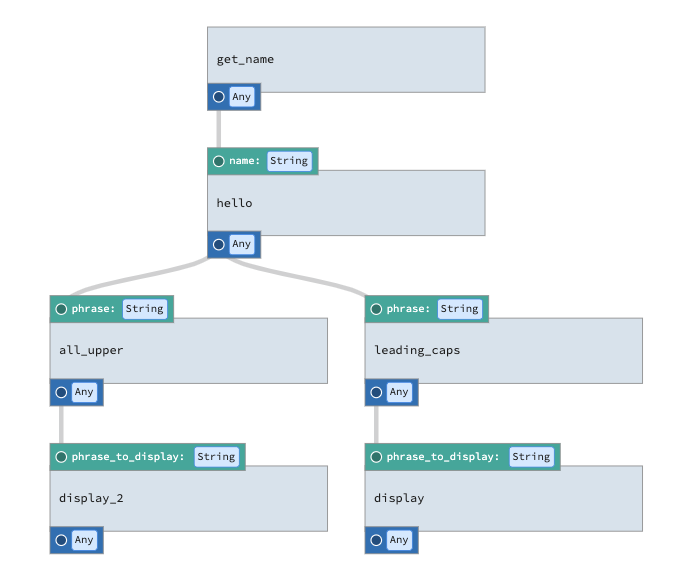

In [48]:
# TODO update
from IPython.display import Image

Image(os.path.join("img", "data_dag_gui.png"))

There are a lot of benefits to thinking about your data processing in terms of pipelines and DAGs. You can see the last time any particular node executed and, if node execution fails, you can see why, where, and how. The GUI has tons of extra functionality too; for instance, you can track what’s produced by your pipelines with the 'Asset Manager', so you can understand how your data was generated and trace issues when it doesn’t look how you expect. There's also optional typing of data types on input and output which helps you to catch bugs in data like you'd catch bugs in code (in the above, we declared all of the input types to be strings but didn't declare what the output types were so they appeared as 'any').

This has barely scratched the surface, but hopefully it's given you an insight into what data orchestration tools do and how they might be helpful for complex data workflows.